## Finite State Projection Algorithm
**Stochastic Kinetics of mRNA Molecules in a General Transcription Model**

*Yuntao Lu and Yunxin Zhang*

School of Mathematical Sciences, Fudan University, Shanghai 200433, China

Email: `yuntaolu22@m.fudan.edu.cn` and `xyz@fudan.edu.cn`

This script implements original Finite State Projection (FSP) algorithm (proposed in
`Munsky, B., and M. Khammash, 2006. The Finite State Projection Algorithm for the Solution of the Chemical Master Equation. J. Chem. Phys. 124:044104.`) to study the general transcription model in our paper. The main objective is to time the running times of FSP. The results are plotted in Figure 4 in our paper.

Note that we only time one final execution of `expm_multiply(A * t , p0)`, which calculates the product $\exp{(tA)}p(0)$. Matrix $A$, or equivalently the subset of states, is determined such that the truncation error, defined as $1-\pmb{1}^T\exp{(tA)}p(0)$, is below the prescribed tolerance $\epsilon=1e-5$. Therefore, the preceding iterative process of expanding the state subset (or equivalently the matrix $A$) to achieve this error bound is excluded from the timing. 

In [1]:
import numpy as np
from scipy.sparse import bmat, csr_matrix, block_diag, diags
from scipy.sparse.linalg import expm_multiply

In [2]:
def construct_block_matrix(D0, D1, delta=1, K=10):
    """
    Construct the block matrix:
    
    [ D0^T           delta I                   ]
    [ D1^T   D0^T-delta I    2 delta I         ]
    [        D1^T      D0^T-2delta I   ...     ]
    [               ...             ...        ]
    [                         D1^T  D0^T-10delta I ]

    Parameters:
    - D0, D1: square numpy arrays or sparse matrices (n x n)
    - delta: scalar
    - K: int, the maximum k (example 10 -> 11 blocks)

    Returns:
    - Sparse matrix of size (n*(K+1), n*(K+1))
    """
    n = D0.shape[0]
    if D0.shape != (n, n) or D1.shape != (n, n):
        raise ValueError("D0 and D1 must be square matrices of the same size")
    
    # Transpose once
    D0T = D0.T
    D1T = D1.T

    # List to hold each row of blocks
    blocks = []

    for k in range(K + 1):  # k from 0 to K
        row_blocks = [None] * (K + 1)
        
        # Main diagonal block: D0^T - k * delta * I
        main_block = D0T - k * delta * np.eye(n)
        row_blocks[k] = main_block
        
        # Upper diagonal: (k+1) * delta * I (only if not last row)
        if k < K:
            upper_block = (k + 1) * delta * np.eye(n)
            row_blocks[k + 1] = upper_block
        
        # Lower diagonal: D1^T (only if not first row)
        if k > 0:
            row_blocks[k - 1] = D1T
        
        blocks.append(row_blocks)
    
    # Use bmat to build block matrix
    result = bmat(blocks, format='csr')  # 或 'csc', 'lil' 等
    return result

In [3]:
import Parameters_for_Figures

In [4]:
# D0=Parameters_for_Figures.D0_3a
# D1=Parameters_for_Figures.D1_3a
# D0=Parameters_for_Figures.D0_3b
# D1=Parameters_for_Figures.D1_3b
# D0=Parameters_for_Figures.D0_3c
# D1=Parameters_for_Figures.D1_3c
D0=Parameters_for_Figures.D0_3d
D1=Parameters_for_Figures.D1_3d
delta=1

In [5]:
Block=10
N=D0.shape[0]


A = construct_block_matrix(D0, D1, delta, K=Block)
A=A.toarray()

T = 10

p0 = np.zeros(N * (Block + 1))
p0[0] = 1  


pT = expm_multiply(A * T, p0)

total=np.sum(pT)
print(total)

0.06911292585643787


In [7]:
tol=1e-5
while total < 1-tol:
    Block+=10
  
    A = construct_block_matrix(D0, D1, delta, K=Block)
    A=A.toarray()
    
    p0 = np.zeros(N * (Block + 1))
    p0[0] = 1 

    # pT is a ndarray of size (N * (Block + 1) , 1)

    pT = expm_multiply(A * T, p0)

    total=np.sum(pT)
    
    print(f"Current Block Number is {Block}; sum of probability is {total}")

print(f"The tolerance is set as {tol} \n Converged with Block Number={Block}\n sum of probability is={total}")

Current Block Number is 20; sum of probability is 0.9969899512692956
Current Block Number is 30; sum of probability is 0.9999999801881084
The tolerance is set as 1e-05 
 Converged with Block Number=30
 sum of probability is=0.9999999801881084


In [8]:
prob=[]
for i in range(Block+1):
    sum_state=np.sum(pT[i*N:i*N+N])
    prob.append(float(sum_state))

In [9]:
# np.save('fig3_FSP_a.npy', prob)
# np.save('fig3_FSP_b.npy', prob)
# np.save('fig3_FSP_c.npy', prob)
# np.save('fig3_FSP_d.npy', prob)

In [9]:
print(prob)

[0.000438254814443973, 0.0034021612660008354, 0.013191671462531387, 0.03406461710867926, 0.06590573734440111, 0.1019045358874556, 0.13117460785606316, 0.14458846276417006, 0.13931809558171512, 0.11921164888432768, 0.09172128928261297, 0.06409656466966723, 0.0410227421387264, 0.02421443969045276, 0.013260787840447198, 0.006772338949685214, 0.003239848484047943, 0.0014575877163778396, 0.0006188443144633971, 0.0002487221402788898, 9.489543667865418e-05, 3.445619397603129e-05, 1.1933582640523588e-05, 3.950519110739933e-06, 1.252346921642142e-06, 3.807807630640172e-07, 1.1116651990707422e-07, 3.114900964589668e-08, 8.32946978965122e-09, 2.06918639393684e-09, 4.1728377443041733e-10]


In [10]:
import matplotlib.pyplot as plt

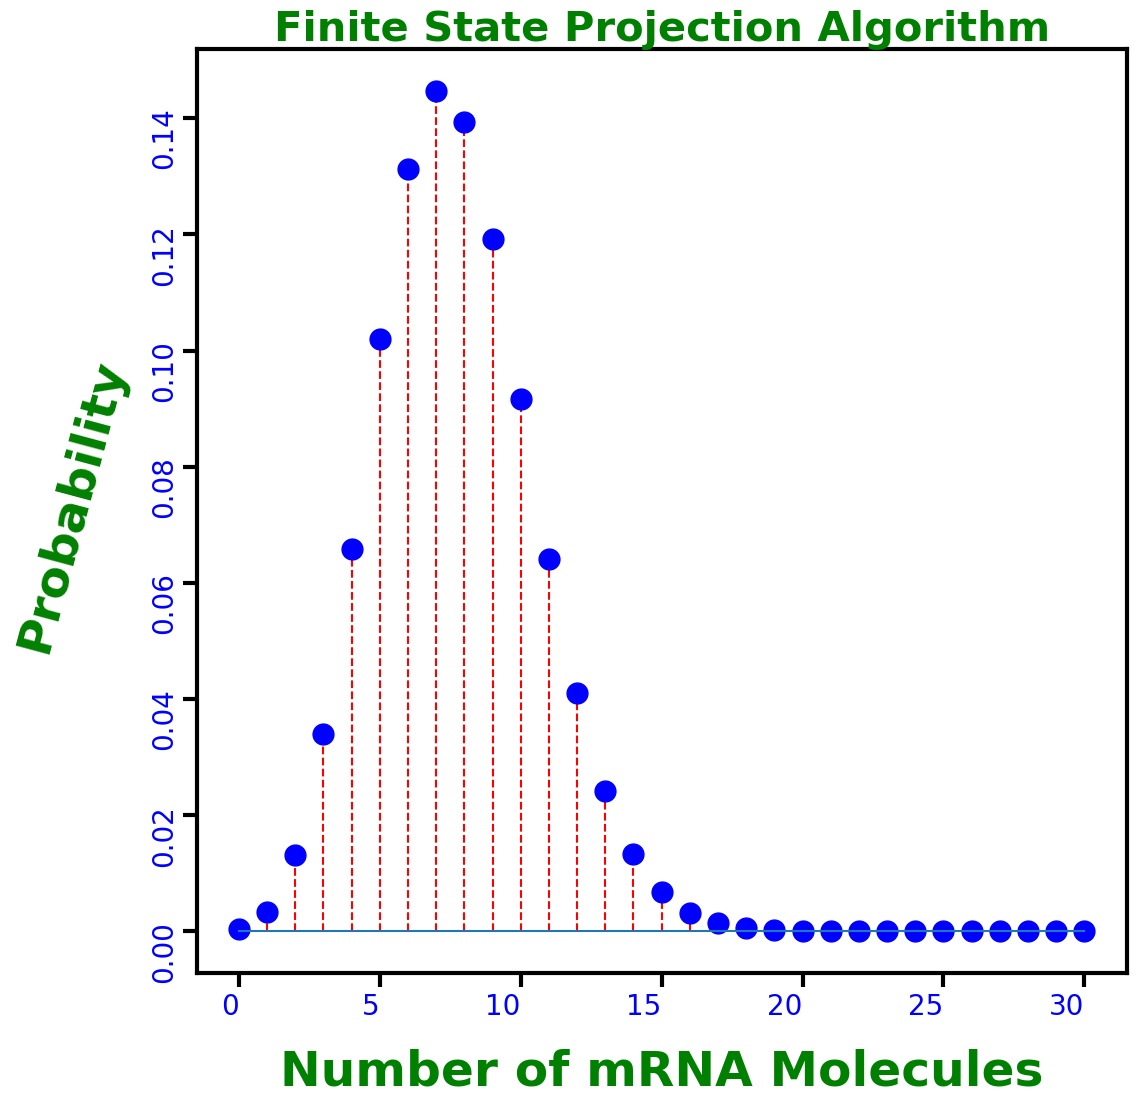

In [12]:
plt.figure(figsize=(12, 12),dpi=100)
plt.rcParams['axes.linewidth'] = 3
plt.stem(list(range(len(prob))), (np.array(prob)).flatten(),linefmt='r--',
         markerfmt='bo',basefmt="",label='FSP')
plt.setp(plt.gca().get_lines(), markersize=15)
# plt.xlim(0, 40)
# plt.ylim(0, 0.1)
plt.xticks(
    # ticks=list(range(0,45,5)),
           fontsize=20,
           color='blue',
           # fontname='Times New Roman',
           fontname='DejaVu Sans',
           ha='right')
plt.yticks(
    # ticks=np.arange(0.02, 0.12, 0.02),
           fontsize=20,
           color='blue',
           rotation=90,
           # fontname='Times New Roman',
           fontname='DejaVu Sans',
           ha='right')
plt.title(f'Finite State Projection Algorithm',
          # fontname='Times New Roman',
           fontname='DejaVu Sans',
          fontsize=30,fontweight='bold',color='green')
plt.xlabel('Number of mRNA Molecules',fontsize=35,fontweight='bold',
           labelpad=20,
           # fontname='Times New Roman',
           fontname='DejaVu Sans',
           color='green')
plt.ylabel('Probability',fontsize=35,fontweight='bold',
           labelpad=40,
           # fontname='Times New Roman',
           fontname='DejaVu Sans',
           color='green',rotation=75)
plt.tick_params(direction='out',width=3,length=10)
plt.show()